<img src="https://i.imgur.com/4ufm7sh.png" width=1200 />




## **🎯      Goal**

It seems your underwater camera has some issues, but you already took a lot of dolphin pictures!
Restore the corrupted images to its original state. The types of corruptions are as follows:

<img src="https://i.imgur.com/XFjUsdJ.png" width=800 />



## **1**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Import Libraries**


In [ ]:
!pip install pytorch-lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 42.1 MB/s eta 0:00:00


In [ ]:
# DATA MANIPULATION
import pandas as pd         # Data manipulation and analysis.
import numpy as np          # Numerical operations and arrays.

# DATA MANAGEMENT
import zipfile              # Reading and writing zip files.
import requests             # Sending HTTP requests (downloading files from the internet).
import io                   # Handling I/O streams (working with byte streams, buffers).
import os                   # Interacting with the operating system (file and directory operations).

# IMAGE PROCESSING
from PIL import Image       # Opening, manipulating, and saving image files.

## **2**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Load Training Dataset**



In [ ]:
import pandas as pd
import requests
import zipfile
import io
from PIL import Image
import os

# URL for the combined zip file
train_url = "https://www.dropbox.com/scl/fi/x0jmwyljm9jhsqka8hs46/dolphins.zip?rlkey=ox9t0yiwljb6cftixtuetj8r9&st=4xqaqdm1&dl=0&raw=1"

# Download and extract the dataset
zipfile.ZipFile(io.BytesIO(requests.get(train_url).content)).extractall("dolphins")

# Save the images as DataFrame
clean_images = {
    img: Image.open(os.path.join("dolphins", img)).convert('RGB')
    for img in os.listdir("dolphins")
    if img.endswith(('.png', '.jpg', '.jpeg'))
}

# Create DataFrame
dolphin_df = pd.DataFrame([
    {
        'image_name': clean_name,
        'clean_image': clean_images[clean_name]
    }
    for clean_name in clean_images.keys()
])

# Print the DataFrame
print(dolphin_df.head())

        image_name                                        clean_image
0  dolphin_987.png  <PIL.Image.Image image mode=RGB size=512x512 a...
1  dolphin_763.png  <PIL.Image.Image image mode=RGB size=512x512 a...
2  dolphin_115.png  <PIL.Image.Image image mode=RGB size=512x512 a...
3  dolphin_828.png  <PIL.Image.Image image mode=RGB size=512x512 a...
4  dolphin_960.png  <PIL.Image.Image image mode=RGB size=512x512 a...


### Making Training Dataset (by Adding Noise to the Clean Image)

#### Making Corruption Functions

In [ ]:
import random
import string
from PIL import Image, ImageFilter
import cv2

# Noise functions
def add_gaussian_noise(image, mean=0, sigma=25):
    image_array = np.array(image)
    noise = np.random.normal(mean, sigma, image_array.shape)
    noisy_image = np.clip(image_array + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

def add_salt_pepper_noise(image, salt_vs_pepper=0.5, amount=0.04):
    image_array = np.array(image)
    num_salt = np.ceil(amount * image_array.size * salt_vs_pepper)
    num_pepper = np.ceil(amount * image_array.size * (1.0 - salt_vs_pepper))

    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image_array.shape]
    image_array[coords[0], coords[1], :] = 255

    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image_array.shape]
    image_array[coords[0], coords[1], :] = 0

    return Image.fromarray(image_array)

def blur_image(image, radius=2):
    return image.filter(ImageFilter.GaussianBlur(radius))

def reduce_resolution(image, factor=0.5):
    width, height = image.size
    new_size = (int(width * factor), int(height * factor))
    return image.resize(new_size, Image.LANCZOS).resize((width, height), Image.NEAREST)

def random_mask(image, num_rectangles=3):
    img_array = np.array(image)
    for _ in range(num_rectangles):
        x, y = np.random.randint(0, img_array.shape[1]), np.random.randint(0, img_array.shape[0])
        w, h = np.random.randint(20, 100), np.random.randint(20, 100)
        cv2.rectangle(img_array, (x, y), (x+w, y+h), (0, 0, 0), -1)
    return Image.fromarray(img_array)

# List of corruption functions
corruptions = [add_gaussian_noise, add_salt_pepper_noise, blur_image, reduce_resolution, random_mask]

def random_alphanumeric(length=5):
    return ''.join(random.choices(string.ascii_uppercase + string.digits, k=length))

def apply_random_noise(image, num_corruptions=2):
    # Randomly select (two) unique corruption functions
    selected_corruptions = random.sample(corruptions, num_corruptions)

    # Apply the selected corruptions
    for corruption in selected_corruptions:
        image = corruption(image)

    return image

#### Applying Corruption Functions

In [ ]:
# Specify the number of samples you want
num_samples = 100  # Adjust as needed

# Randomly sample from dolphin_df
sampled_df = dolphin_df.sample(n=num_samples, replace=True)

# Create and populate train_df
train_df = pd.DataFrame({
    'image_name': [f"dolphin_{random_alphanumeric()}.jpg" for _ in range(num_samples)],
    'clean_image': [row['clean_image'] for _, row in sampled_df.iterrows()],
    'corrupted_image': [apply_random_noise(row['clean_image']) for _, row in sampled_df.iterrows()]
})

print(train_df)

           image_name                                        clean_image  \
0   dolphin_015PI.jpg  <PIL.Image.Image image mode=RGB size=512x512 a...   
1   dolphin_C7QWD.jpg  <PIL.Image.Image image mode=RGB size=512x512 a...   
2   dolphin_KEW1G.jpg  <PIL.Image.Image image mode=RGB size=512x512 a...   
3   dolphin_9FL7O.jpg  <PIL.Image.Image image mode=RGB size=512x512 a...   
4   dolphin_6LU9K.jpg  <PIL.Image.Image image mode=RGB size=512x512 a...   
..                ...                                                ...   
95  dolphin_QHE19.jpg  <PIL.Image.Image image mode=RGB size=512x512 a...   
96  dolphin_BBLII.jpg  <PIL.Image.Image image mode=RGB size=512x512 a...   
97  dolphin_UDSGT.jpg  <PIL.Image.Image image mode=RGB size=512x512 a...   
98  dolphin_48QH3.jpg  <PIL.Image.Image image mode=RGB size=512x512 a...   
99  dolphin_1AOOP.jpg  <PIL.Image.Image image mode=RGB size=512x512 a...   

                                      corrupted_image  
0   <PIL.Image.Image image mode

### Visualize the Training Dataset

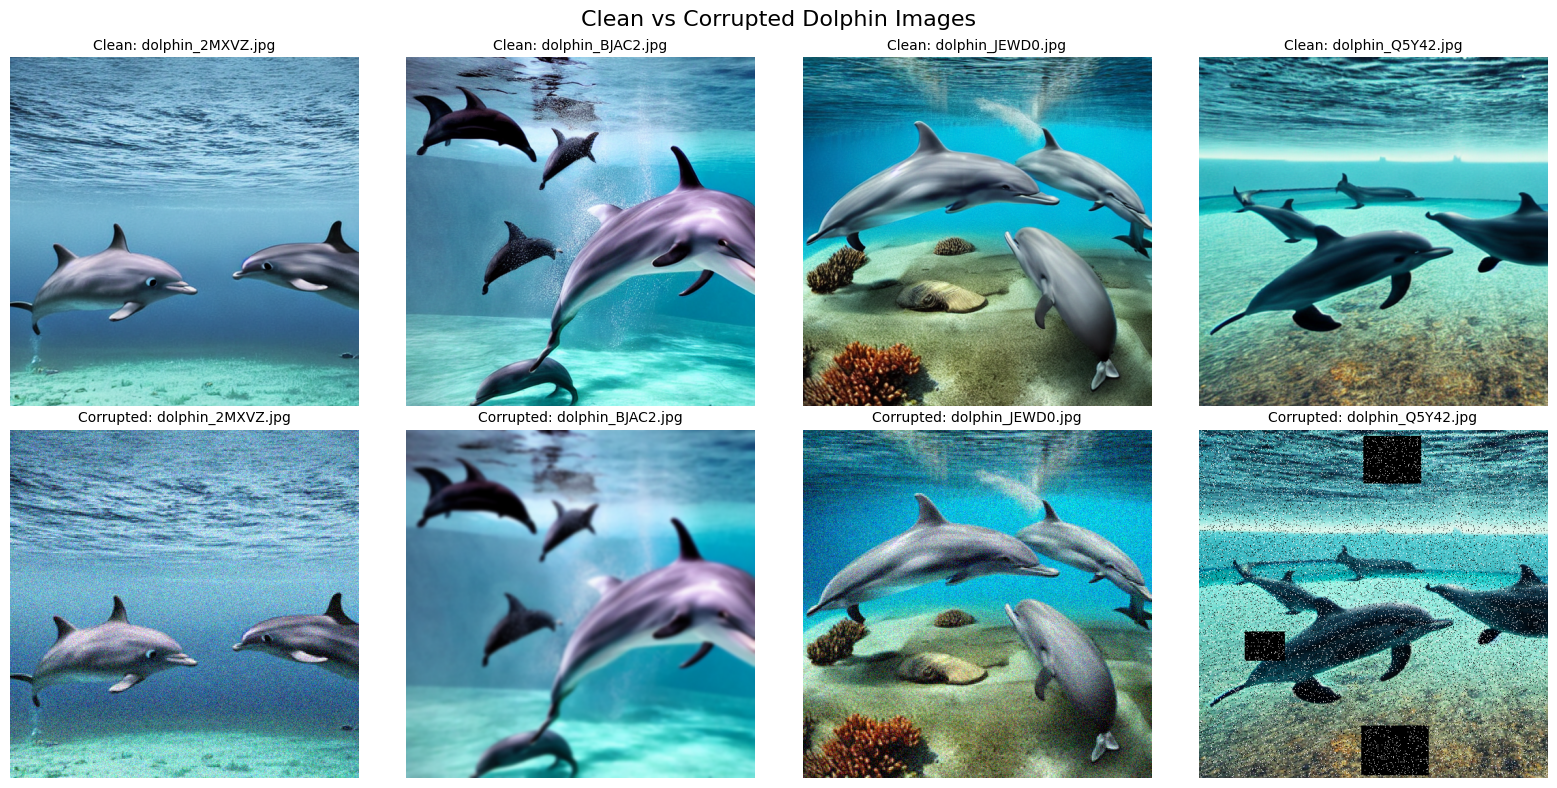

In [ ]:
import matplotlib.pyplot as plt
import random

def visualize_image_pairs(dataframe, num_pairs=4):
    # Ensure we don't try to display more pairs than we have in the dataframe
    num_pairs = min(num_pairs, len(dataframe))

    # Set up the plot
    fig, axes = plt.subplots(2, num_pairs, figsize=(4*num_pairs, 8))
    fig.suptitle("Clean vs Corrupted Dolphin Images", fontsize=16)

    # Randomly select image pairs
    sample_df = dataframe.sample(n=num_pairs)

    for i, (_, row) in enumerate(sample_df.iterrows()):
        clean_image = row['clean_image']
        corrupted_image = row['corrupted_image']
        image_name = row['image_name']

        # Display clean image
        axes[0, i].imshow(clean_image)
        axes[0, i].set_title(f"Clean: {image_name}", fontsize=10)
        axes[0, i].axis('off')

        # Display corrupted image
        axes[1, i].imshow(corrupted_image)
        axes[1, i].set_title(f"Corrupted: {image_name}", fontsize=10)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
visualize_image_pairs(train_df, num_pairs=4)

## **3**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Create Dataset Class**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

image_size = 224
class ImageReconstructionDataset(Dataset):
    def __init__(self, dataframe, is_test=False):
        self.dataframe = dataframe
        self.is_test = is_test
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        corrupted_image = self.transform(row['corrupted_image'])

        if self.is_test:
            return corrupted_image, row['image_name']
        else:
            clean_image = self.transform(row['clean_image'])
            return corrupted_image, clean_image


## **4**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Create Training Set**


In [ ]:
# Assuming dolphin_df is your DataFrame with the image data
dataset = ImageReconstructionDataset(train_df)

# Create DataLoader
batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

## **5**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Create Neural Network Class**

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

class AdvancedAutoencoder(pl.LightningModule):
    def __init__(self, in_channels=3, latent_dim=256):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(512 * 14 * 14, latent_dim)
        )

        # Decoder
        self.decoder_dense = nn.Linear(latent_dim, 512 * 14 * 14)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (512, 14, 14)),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, in_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        z = self.decoder_dense(z)
        return self.decoder(z)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = nn.MSELoss()(x_hat, x)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# Create the autoencoder
model = AdvancedAutoencoder()
print(model)

## **6**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Train the Neural Network**

In [ ]:
from pytorch_lightning import Trainer
torch.cuda.empty_cache()

trainer = Trainer(max_epochs=10)
trainer.fit(model, train_loader)

## **7**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Load the Testset**

In [ ]:
# URL for test images
test_url = "https://www.dropbox.com/scl/fi/1wx237173e6ev9ud7bt5k/test_dolphin.zip?rlkey=37kt777e6yba0thzt76pzcvfq&st=akc18wx7&dl=0&raw=1"

# Download and extract test dataset
zipfile.ZipFile(io.BytesIO(requests.get(test_url).content)).extractall("corrupted_dolphin_images")

# Process test images
test_images = {
    img: Image.open(os.path.join("corrupted_dolphin_images/corrupted_dolphin_images", img)).convert('RGB')
    for img in os.listdir("corrupted_dolphin_images/corrupted_dolphin_images")
    if img.endswith(('.png', '.jpg', '.jpeg'))
}

# Create DataFrame for test set
test_dolphin_df = pd.DataFrame([
    {
        'image_name': image_name,
        'corrupted_image': image
    }
    for image_name, image in test_images.items()
])

# Print the DataFrame
print(test_dolphin_df.head())
print(f"Total test images: {len(test_dolphin_df)}")

                      image_name  \
0  test_corrupted_dolphin_16.png   
1   test_corrupted_dolphin_8.png   
2  test_corrupted_dolphin_13.png   
3   test_corrupted_dolphin_5.png   
4   test_corrupted_dolphin_3.png   

                                     corrupted_image  
0  <PIL.Image.Image image mode=RGB size=512x512 a...  
1  <PIL.Image.Image image mode=RGB size=512x512 a...  
2  <PIL.Image.Image image mode=RGB size=512x512 a...  
3  <PIL.Image.Image image mode=RGB size=512x512 a...  
4  <PIL.Image.Image image mode=RGB size=512x512 a...  
Total test images: 20


## **8**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Make Prediction**

In [ ]:
# Create a DataFrame with the predictions
pred_df = test_dolphin_df.rename(columns={'corrupted_image': 'clean_image'}).copy()

# Merge with the original test DataFrame
result_df = pd.merge(test_dolphin_df, pred_df, on='image_name')

print(result_df.head())
print(f"Total predictions: {len(result_df)}")

                      image_name  \
0  test_corrupted_dolphin_16.png   
1   test_corrupted_dolphin_8.png   
2  test_corrupted_dolphin_13.png   
3   test_corrupted_dolphin_5.png   
4   test_corrupted_dolphin_3.png   

                                     corrupted_image  \
0  <PIL.Image.Image image mode=RGB size=512x512 a...   
1  <PIL.Image.Image image mode=RGB size=512x512 a...   
2  <PIL.Image.Image image mode=RGB size=512x512 a...   
3  <PIL.Image.Image image mode=RGB size=512x512 a...   
4  <PIL.Image.Image image mode=RGB size=512x512 a...   

                                         clean_image  
0  <PIL.Image.Image image mode=RGB size=512x512 a...  
1  <PIL.Image.Image image mode=RGB size=512x512 a...  
2  <PIL.Image.Image image mode=RGB size=512x512 a...  
3  <PIL.Image.Image image mode=RGB size=512x512 a...  
4  <PIL.Image.Image image mode=RGB size=512x512 a...  
Total predictions: 20


### Visualize the Predictions

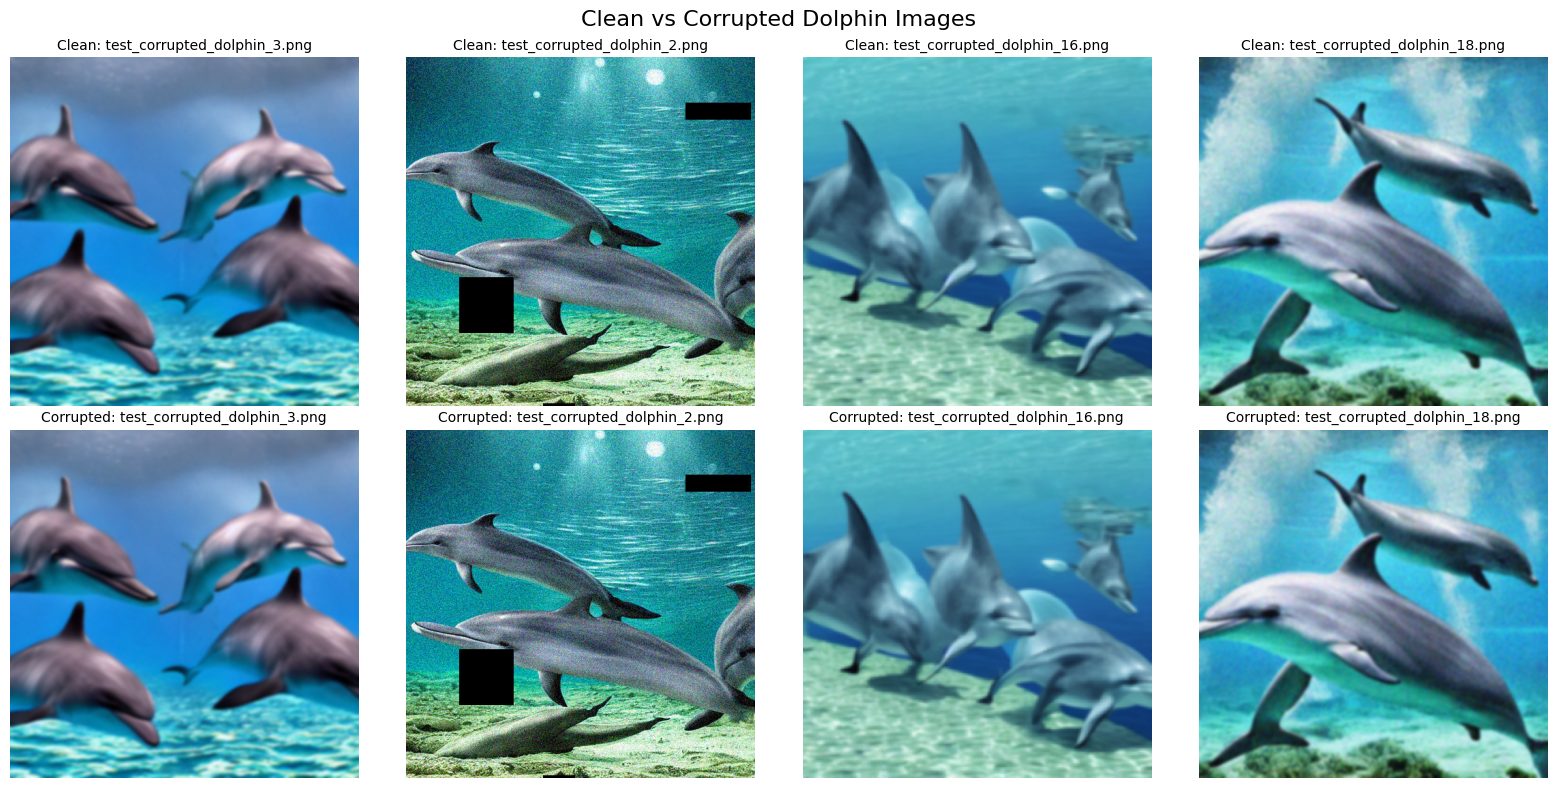

In [ ]:
visualize_image_pairs(result_df, num_pairs=4)


## **9**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Create Submission File**
Do not change this code as the random seed and code architecture determine the pixel order.


In [ ]:
# Function for submission (do not change!)
def select_random_pixels(image, num_pixels=100, seed=None):
    rng = np.random.default_rng(seed)
    pixels = np.array(image).reshape(-1, 3)
    return pixels[rng.choice(pixels.shape[0], num_pixels, replace=False)].flatten()

def create_competition_df(result_df, base_seed=42):
    competition_data = []

    for idx, row in result_df.iterrows():
        # Create a unique seed for each image
        image_seed = base_seed + idx
        random_pixels = select_random_pixels(row['clean_image'], seed=image_seed)

        competition_data.append(
            {'image_name': row['image_name'],
             **{f'pixel_{i}': value for i, value in enumerate(random_pixels)}}
        )

    return pd.DataFrame(competition_data)

In [ ]:
submission_df = create_competition_df(result_df)
submission_df.to_csv('submission.csv', index=False)

## <font color="#FF8888">▝</font><font color="#707DA0">▖   </font>**Download File**

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>